# GNN Training

In [1]:
import os
import torch
import gc

from gnn_model.HeteroGAT import HeteroGAT
from gnn_model.trainer import Trainer
from data_processing.data_loader import DataLoader
from data_processing.config import DataProcessingConfig

In [2]:
from torch_geometric.data import Batch
import torch

def custom_collate(data_list):
    """Custom collate function to handle varying tensor sizes"""
    if len(data_list) == 0:
        return None
    
    # Get all keys from the first data object
    keys = [key for key in data_list[0].keys if torch.is_tensor(data_list[0][key])]
    
    # Find the maximum size for each tensor
    max_sizes = {}
    for key in keys:
        if len(data_list[0][key].shape) > 1:  # Only for 2D or higher tensors
            max_size = max(data.get(key).shape[1] for data in data_list if key in data)
            max_sizes[key] = max_size
    
    # Pad tensors to maximum size
    for data in data_list:
        for key in keys:
            if key in max_sizes and key in data:
                tensor = data[key]
                if tensor.shape[1] < max_sizes[key]:
                    padding_size = max_sizes[key] - tensor.shape[1]
                    padding = torch.zeros((tensor.shape[0], padding_size), 
                                       dtype=tensor.dtype, 
                                       device=tensor.device)
                    data[key] = torch.cat([tensor, padding], dim=1)
    
    return Batch.from_data_list(data_list)

In [3]:
import torch.serialization
from torch_geometric.data.storage import BaseStorage

# Add BaseStorage class to safe globals for loading
torch.serialization.add_safe_globals([BaseStorage])

## Data Preparation

In [4]:
# Scenarios
case_study = 'manhattan_case_study'
results_dir = os.path.join('..', 'studies', case_study, 'results')
scenario_names = [
    # 'gnn_ex1', 'gnn_ex2', # 'gnn_ex3', 'gnn_ex4'
    #        'example_pool_sc_1'
    'test_manhattan_scenario_1', 'test_manhattan_scenario_2', 'test_manhattan_scenario_3',
    'test_manhattan_scenario_4'
]
                  
scenarios = [os.path.join(results_dir, sc) for sc in scenario_names]

# Create config
config = DataProcessingConfig(
    sim_duration=86400,
)

# Set to True only when data needs to be reprocessed
overwrite = True

In [5]:
# random seed for reproducibility
torch.manual_seed(config.random_seed)

In [6]:
# Safe data loading with error handling
def load_data_safely():
    try:
        gc.collect()  # Clean up memory before loading
        torch.cuda.empty_cache()  # Clear GPU cache if available
        
        loader = DataLoader(scenarios, config, overwrite=overwrite)
        data, *masks = loader.load_data()
        
        # Validate loaded data
        if not data or len(data) == 0:
            raise ValueError("No data was loaded")
            
        return data, masks
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None

data, masks = load_data_safely()
train_masks, val_masks, test_masks = masks if masks else (None, None, None)

  0%|          | 0/4 [00:00<?, ?it/s]

Error processing timestep 44460: 3261462
Failed timesteps: [44460]


 25%|██▌       | 1/4 [01:01<03:05, 61.94s/it]

Data split: Train=1007, Val=215, Test=217


 50%|█████     | 2/4 [02:05<02:06, 63.14s/it]

Data split: Train=1007, Val=216, Test=217


 75%|███████▌  | 3/4 [03:09<01:03, 63.29s/it]

Data split: Train=1007, Val=216, Test=217


100%|██████████| 4/4 [04:08<00:00, 62.13s/it]

Data split: Train=1007, Val=216, Test=217


In [7]:
# Validate loaded data
if data is not None:
    print(f"Successfully loaded {len(data)} data points")
    print(f"Train/Val/Test split: {sum(train_masks)}/{sum(val_masks)}/{sum(test_masks)}")
else:
    print("Failed to load data. Please check the error message above.")

Successfully loaded 5759 data points
Train/Val/Test split: 4028/863/868


## Model Setup

In [8]:
# Model parameters
num_classes = 1  # Changed to 1 for binary classification
hidden_channels = 64
epochs = 200
batch_size = 32

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [9]:
# Model parameters
num_classes = 1  # Binary classification - single output logit with sigmoid activation
hidden_channels = 64  # Size of hidden layers in GNN
epochs = 200  # Maximum number of training epochs (may stop earlier due to early stopping)
batch_size = 32  # Number of graphs per batch

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model with error handling
model = HeteroGAT(hidden_channels, num_classes).to(device=device)
print(f"Model initialized with {hidden_channels} hidden channels and {num_classes} output channel")

Using device: cpu
Model initialized with 64 hidden channels and 1 output channel


In [10]:
# Training setup with weighted BCE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
trainer = Trainer(data, device, masks, config, batch_size=batch_size)

Filtered 1 empty graphs from dataset

Training Configuration
--------------------------------------------------------------------------------
Batch Size:          32
Max Epochs:          200
Device:              cpu
Pos Weight:          25.1155
--------------------------------------------------------------------------------


/Users/hoda_hamdy/Documents/Projects/fleetpy/FleetPy/notebooks/gnn_model/trainer.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(neg_pos_ratio, device=self.device)


In [ ]:
# Training with progress tracking and error handling
try:
    # Add numpy scalar to safe globals before training
    import torch.serialization
    torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])
    
    # Start training
    trainer.train(model, optimizer)
except Exception as e:
    print(f"Error during training: {str(e)}")
    # Print more detailed error information
    import traceback
    traceback.print_exc()

## Visualization

Let's visualize a sample graph from our dataset and analyze model predictions.

### Graph Visualization Functions

The following cells implement visualization functionality for our heterogeneous graph neural network:

1. Node visualization:
   - Vehicles: red nodes
   - Requests: turquoise nodes

2. Edge visualization:
   - True assignments: solid red lines
   - Non-assignments: dotted gray lines
   - Predicted assignments: semi-transparent blue lines (with probability scores)

3. Additional features:
   - Node labels (V for vehicles, R for requests)
   - Edge probability labels for predicted assignments
   - Comprehensive legend
   - Force-directed layout for clear visualization

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def get_edge_predictions(data, graph_idx, model, device):
    """Get model predictions for a single graph"""
    model.eval()
    with torch.no_grad():
        # Prepare data dictionaries
        graph = data[graph_idx].to(device)
        
        # Prepare input dictionaries
        x_dict = {}
        edge_index_dict = {}
        edge_attr_dict = {}
        
        # Get node features
        for node_type in graph.node_types:
            x_dict[node_type] = graph[node_type].x
        
        # Get edge features
        for edge_type in graph.edge_types:
            edge_index = graph[edge_type].edge_index
            edge_attr = graph[edge_type].edge_attr

            edge_index_dict[edge_type] = edge_index.long()  # Ensure int64
            edge_attr_dict[edge_type] = edge_attr
        
        try:
            logits = model(x_dict, edge_index_dict, edge_attr_dict)
            return torch.sigmoid(logits).cpu().numpy()
        except Exception as e:
            print(f"Error during prediction: {str(e)}")
            return None

In [ ]:
def visualize_graph(data, graph_idx=0, model=None, device=None):
    """Visualize a heterogeneous graph with vehicle-request assignments"""
    G = nx.Graph()
    
    # Color scheme
    colors = {
        'vehicle': '#FF6B6B',    # Red for vehicles
        'request': '#4ECDC4',    # Turquoise for requests
    }
    
    # Get predictions if model is provided
    predictions = None
    if model is not None and device is not None:
        predictions = get_edge_predictions(data, graph_idx, model, device)

    # Add nodes
    node_colors = []
    node_sizes = []
    node_labels = {}
    
    # Only process vehicle and request nodes
    for node_type in ['vehicle', 'request']:
        if node_type in data[graph_idx].node_types:
            nodes = data[graph_idx][node_type]
            for i in range(nodes.x.size(0)):
                node_name = f'{node_type}_{i}'
                G.add_node(node_name, type=node_type)
                node_colors.append(colors[node_type])
                node_sizes.append(400 if node_type == 'vehicle' else 300)
                node_labels[node_name] = f'{node_type[0].upper()}{i}'
    
    # Process edges and their attributes
    edge_count = 0
    true_edges = []
    true_colors = []
    true_styles = []
    pred_edges = []
    pred_labels = {}
    
    for edge_type in data[graph_idx].edge_types:
        src_type, rel_type, dst_type = edge_type
        edge_index = data[graph_idx][edge_type].edge_index
        edge_y = data[graph_idx][edge_type].y

        for i in range(edge_index.size(1)):
            src = f'{src_type}_{edge_index[0][i].item()}'
            dst = f'{dst_type}_{edge_index[1][i].item()}'
            G.add_edge(src, dst)


            # Add ground truth
            true_edges.append((src, dst))
            if edge_y is not None and edge_y[i].item() == 1:
                true_colors.append('#FF9999')  # Light red for assignments
                true_styles.append('solid')
            else:
                true_colors.append('#CCCCCC')  # Gray for non-assignments
                true_styles.append('dotted')

            # Add predictions
            if predictions is not None and edge_count < len(predictions):
                prob = predictions[edge_count][0]
                if prob > 0.5:
                    pred_edges.append((src, dst))
                    pred_labels[(src, dst)] = f'{prob:.2f}'
                edge_count += 1
    
    # Create plot
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_labels(G, pos, node_labels, font_size=10)
    
    # Draw ground truth edges
    for (u, v), color, style in zip(true_edges, true_colors, true_styles):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color,
                              style=style, alpha=0.8)
    
    # Draw predicted edges with an offset
    if predictions is not None:
        # Create a small offset for predicted edges
        edge_offset = 0.03  # Adjust this value to control separation
        for edge in pred_edges:
            u, v = edge
            # Get the original positions
            pos_u, pos_v = np.array(pos[u]), np.array(pos[v])
            # Calculate the perpendicular offset
            dx = pos_v[0] - pos_u[0]
            dy = pos_v[1] - pos_u[1]
            length = np.sqrt(dx*dx + dy*dy)
            # Get perpendicular direction
            perpx, perpy = -dy/length, dx/length
            # Apply offset
            new_pos_u = pos_u + np.array([perpx, perpy]) * edge_offset
            new_pos_v = pos_v + np.array([perpx, perpy]) * edge_offset
            
            # Draw the offset edge
            plt.plot([new_pos_u[0], new_pos_v[0]], 
                    [new_pos_u[1], new_pos_v[1]], 
                    color='#0000FF', linewidth=2, alpha=0.6,
                    linestyle='--', zorder=1)
            
            # Add probability label at midpoint of offset edge
            if edge in pred_labels:
                mid_x = (new_pos_u[0] + new_pos_v[0]) / 2
                mid_y = (new_pos_u[1] + new_pos_v[1]) / 2
                plt.annotate(pred_labels[edge], 
                           (mid_x, mid_y),
                           bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                           fontsize=8)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Vehicle',
                   markerfacecolor=colors['vehicle'], markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Request',
                   markerfacecolor=colors['request'], markersize=10),
        plt.Line2D([0], [0], color='#FF9999', label='True Assignment', linestyle='solid',
                   alpha=0.8),
        plt.Line2D([0], [0], color='#CCCCCC', label='No Assignment', linestyle='dotted',
                   alpha=0.8)
    ]
    
    if predictions is not None:
        legend_elements.append(
            plt.Line2D([0], [0], color='#0000FF', label='Model Prediction',
                       linestyle='--', alpha=0.6, linewidth=2)
        )
    
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Vehicle-Request Assignment Graph')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

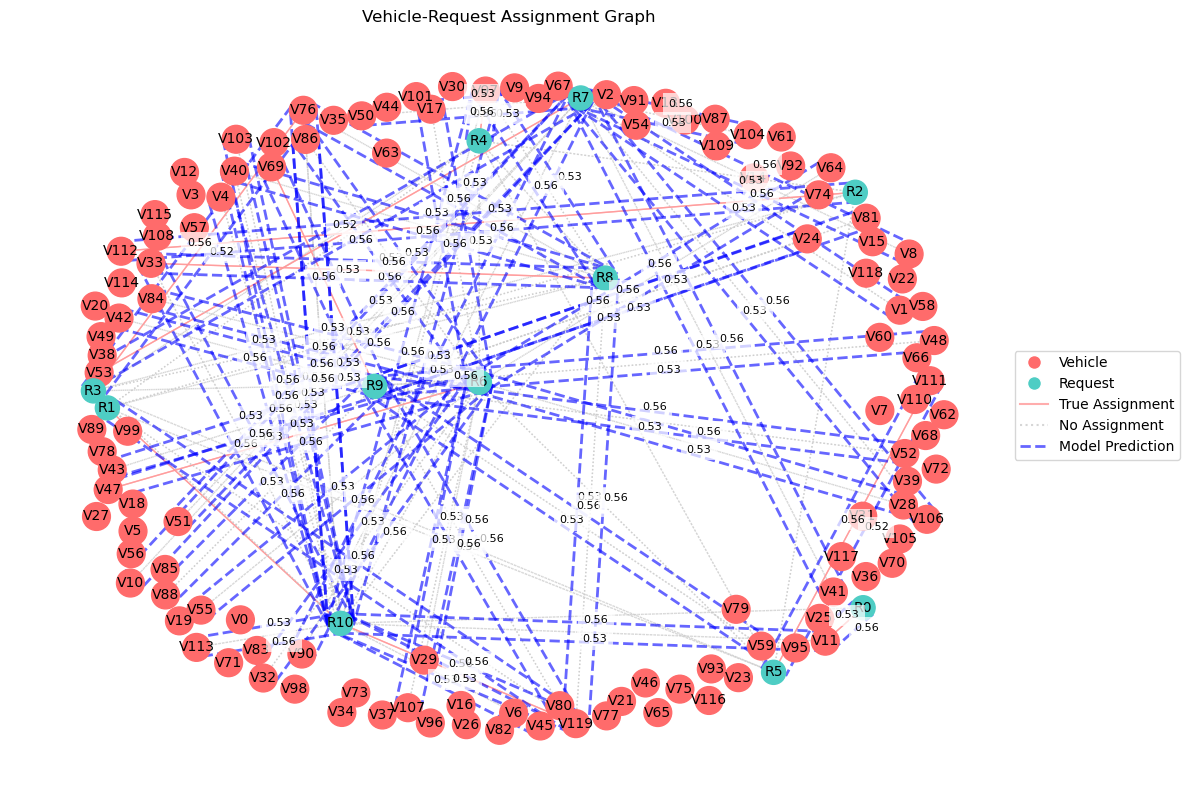

In [ ]:
visualize_graph(data, graph_idx=6, model=model, device=device)